In [2]:
import re
import numpy as np
import pandas as pd
import nfl_data_py as nfl
import matplotlib.pyplot as plt

In [3]:
seasons = range (2015,2026)
data = nfl.import_pbp_data(seasons)

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.


In [4]:
print(data.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'offense_names', 'defense_names',
       'offense_positions', 'defense_positions', 'offense_numbers',
       'defense_numbers'],
      dtype='object', length=398)


Podriamos crear varias data sets separando las columnas por el interes o area de juego, aplicar PCA y matriz de covarianza.


In [5]:
print(data.dtypes.value_counts())

float32    205
object     185
int32        7
int64        1
Name: count, dtype: int64


In [6]:
data.play_deleted.unique()

array([0., 1.], dtype=float32)

In [7]:
GROUP_RULES = {
    "ident_contexto": [
        r"^game_id$", r"nflverse_game_id", r"old_game_id", r"^season$", r"season_type",
        r"^week$", r"game_date", r"start_time", r"time_of_day", r"stadium", r"stadium_id",
        r"location", r"roof", r"surface", r"weather", r"^temp$", r"^wind$", r"div_game",
        r"home_coach", r"away_coach"
    ],

    "marcador_tiempo": [
        r"home_score", r"away_score", r"total_home_score", r"total_away_score",
        r"posteam_score", r"posteam_score_post", r"defteam_score", r"defteam_score_post",
        r"score_differential", r"score_differential_post", r"^result$", r"^total$",
        r"^game_half$", r"^qtr$", r"quarter_seconds_remaining", r"half_seconds_remaining",
        r"game_seconds_remaining", r"end_clock_time", r"play_clock",
        # nuevas
        r"^quarter_end$", r"^time$",
        r"^(home|away)_wp(_post)?$"
    ],

    "posesion_timeouts": [
        r"^posteam$", r"posteam_type", r"possession_team", r"^defteam$", r"return_team",
        r"td_team", r"home_timeouts_remaining", r"away_timeouts_remaining",
        r"posteam_timeouts_remaining", r"defteam_timeouts_remaining", r"^timeout$",
        r"timeout_team", r"home_team", r"away_team"
    ],

    "jugada_drive": [
        r"^play$", r"^play_id$", r"play_type", r"^desc$", r"play_deleted",
        r"^drive", r"drive_.*", r"^fixed_drive", r"fixed_drive_result",
        # nuevas
        r"^series$", r"^series_result$", r"^series_success$",
        r"^end_yard_line$", r"^players_on_play$"
    ],

    "downs_yardas": [
        r"^down$", r"^ydstogo$", r"yardline_100", r"side_of_field", r"goal_to_go",
        r"yards_gained", r"^ydsnet$", r"rushing_yards", r"passing_yards",
        r"receiving_yards", r"yards_after_catch", r"^ngs_air_yards$",
        # nueva
        r"^yrdln$"
    ],

    "eventos_clave": [
        r"touchdown", r"rush_touchdown", r"pass_touchdown", r"return_touchdown",
        r"field_goal_attempt", r"field_goal_result", r"fg_prob", r"extra_point_attempt",
        r"extra_point_result", r"extra_point_prob", r"two_point_attempt",
        r"two_point_conv_result", r"two_point_conversion_prob", r"^safety$", r"safety_prob",
        r"^interception$", r"^fumble", r"^sack$", r"out_of_bounds", r"^touchback$",
        r"^aborted_play$", r"^no_huddle$", r"^shotgun$", r"special_teams_play",
        # nuevas
        r"^td_player_", r"^td_prob$",
        r"^first_down(_rush|_pass|_penalty)?$", r"^first_down$",
        r"^(third|fourth)_down_(converted|failed)$",
        r"^penalty(_team|_player_id|_player_name|_yards|_type)?$",
        r"^defensive_(two_point_conv|extra_point_conv)$"
    ],

    "metricas_avanzadas": [
        r"^epa$", r"^ep$", r"^wp$", r"^wpa$", r"^def_wp$", r"air_epa", r"air_wpa",
        r"comp_air_epa", r"comp_yac_epa", r"comp_air_wpa", r"comp_yac_wpa",
        r"pass_epa", r"rush_epa", r"vegas_wp", r"vegas_wpa", r"vegas_home_wp",
        r"vegas_home_wpa", r"vegas|spread_line|total_line", r"no_score_prob",
        r"opp_(fg|td|safety)_prob", r"^xpass$", r"^cp$", r"^cpoe$", r"^qb_epa$",
        r"^xyac_", r"^yac_epa$", r"^yac_wpa$",
        # nueva
        r"^success$"
    ],

    "ofensiva": [
        r"offense_formation", r"offense_personnel", r"^offense_players$", r"^n_offense$",
        r"^pass(er)?(_|$)", r"^pass(_|$)", r"pass_length", r"pass_location", r"^receiver",
        r"^receiv", r"yards_after_catch", r"^route$", r"^time_to_throw$",
        # nuevas
        r"^qb_dropback$", r"^qb_kneel$", r"^qb_spike$", r"^qb_scramble$",
        r"^air_yards$", r"^incomplete_pass$", r"^complete_pass$"
    ],

    "defensiva": [
        r"defense_personnel", r"^defense_players$", r"^n_defense$", r"defenders_in_box",
        r"defense_coverage_type", r"defense_man_zone_type", r"^pass_defense_",
        r"^sack_player_", r"^qb_hit", r"tackle_for_loss_", r"^solo_tackle", r"^assist_tackle",
        r"tackle_with_assist", r"forced_fumble_player_", r"fumble_recovery_",
        # nuevas
        r"^tackled_for_loss$", r"^interception_player_",
        r"^half_sack_", r"^safety_player_", r"^number_of_pass_rushers$",
        r"^was_pressure$"
    ],

    "rushing": [
        r"^rush(_|$)", r"^rusher", r"run_gap", r"run_location", r"lateral_rush",
        r"lateral_rusher_", r"lateral_rushing_yards"
    ],

    "kicking_punting": [
        r"kicker_", r"^kick(distance|off_)", r"kickoff_", r"own_kickoff_",
        r"punter_", r"^punt_", r"punt_returner_",
        # nuevas
        r"^kick_distance$", r"^home_opening_kickoff$", r"^return_yards$",
        r"^blocked_player_"
    ],

    "laterales": [
        r"lateral_interception_", r"lateral_kickoff_returner_", r"lateral_punt_returner_",
        r"lateral_receiver_", r"^lateral_reception$", r"lateral_receiving_yards",
        r"lateral_sack_", r"^lateral_return$", r"^lateral_recovery$"
    ],

    "fantasy": [
        r"^fantasy", r"fantasy_"
    ],

    "metadatos_varios": [
        r"^id$", r"^order_sequence$", r"^sp$", r"^st_play_type$", r"^name$",
        r"^jersey_number$", r"nfl_api_id", r"replay_or_challenge",
        r"replay_or_challenge_result", r"^special$"
    ],

    "totales_equipo": [
        r"^total_(home|away)_"
    ],
}


In [8]:
cols = list(data.columns)
def group_columns(columns, rules=GROUP_RULES):
    grouped = {k: [] for k in rules}
    assigned = set()
    for col in columns:
        hit = False
        for group, patterns in rules.items():
            if any(re.search(pat, col) for pat in patterns):
                grouped[group].append(col)
                assigned.add(col)
                hit = True
        if not hit:
            grouped.setdefault("otros_no_clasificados", []).append(col)
    return grouped

groups = group_columns(cols)

# Resumen rápido
summary = {g: len(v) for g, v in groups.items()}
summary

{'ident_contexto': 26,
 'marcador_tiempo': 25,
 'posesion_timeouts': 14,
 'jugada_drive': 32,
 'downs_yardas': 15,
 'eventos_clave': 67,
 'metricas_avanzadas': 49,
 'ofensiva': 35,
 'defensiva': 73,
 'rushing': 14,
 'kicking_punting': 34,
 'laterales': 14,
 'fantasy': 4,
 'metadatos_varios': 10,
 'totales_equipo': 28,
 'otros_no_clasificados': 6}

In [9]:
print(data['season_type'].unique())
#Solo hay juegos de temporada regular y postemprada
DataOfensiva = data[cols]
exact_cols = [
    'season','season_type','week','time_of_day','stadium','weather',
    'div_game','surface','home_coach','away_coach',
    'home','away','drive','play','play_type','play_deleted',
    'touchdown','rush_touchdown','pass_touchdown','return_touchdown',
    'field_goal_attempt','field_goal_result','extra_point_attempt',
    'extra_point_result','extra_point_prob','two_point_attempt',
    'two_point_conv_result','two_point_conversion_prob',
    'safety','safety_prob','interception','fumble','sack',
    'out_of_bounds','touchback','aborted_play','no_huddle','shotgun',
    'special_teams_play','offense_formation','offense_personnel',
    'offense_players','n_offense',
    'passer','pass','pass_length','pass_location',
    'receiver','yards_after_catch','route','time_to_throw',
    'qb_dropback','qb_kneel','qb_spike','qb_scramble',
    'air_yards','incomplete_pass','complete_pass'
]

['REG' 'POST']


In [10]:
groups['ofensiva']

['qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'incomplete_pass',
 'pass_attempt',
 'pass_touchdown',
 'complete_pass',
 'passer_player_id',
 'passer_player_name',
 'receiver_player_id',
 'receiver_player_name',
 'receiving_yards',
 'pass_defense_1_player_id',
 'pass_defense_1_player_name',
 'pass_defense_2_player_id',
 'pass_defense_2_player_name',
 'passer',
 'passer_jersey_number',
 'receiver',
 'receiver_jersey_number',
 'pass',
 'passer_id',
 'receiver_id',
 'pass_oe',
 'offense_formation',
 'offense_personnel',
 'offense_players',
 'n_offense',
 'time_to_throw',
 'route']

In [11]:
regular_ssn = data[data['season_type']=='REG']

In [12]:
post_ssn = data[data['season_type']=='POST']

In [13]:
regular_ssn = regular_ssn.loc[:, groups['ofensiva']]

In [14]:
regular_ssn = regular_ssn.drop(['offense_players','passer_player_id','passer_player_name','receiver_player_id','receiver_player_name','pass_defense_1_player_id',
 'pass_defense_1_player_name','pass_defense_2_player_id','pass_defense_2_player_name','passer_jersey_number','receiver_jersey_number','passer_id', 'receiver_id'],axis=1)

In [15]:
regular_ssn['passer'].isna().sum()

np.int64(260325)

In [16]:
regular_ssn.dtypes

qb_dropback          float32
qb_kneel             float32
qb_spike             float32
qb_scramble          float32
pass_length           object
pass_location         object
air_yards            float32
yards_after_catch    float32
incomplete_pass      float32
pass_attempt         float32
pass_touchdown       float32
complete_pass        float32
receiving_yards      float32
passer                object
receiver              object
pass                 float32
pass_oe              float32
offense_formation     object
offense_personnel     object
n_offense            float32
time_to_throw        float32
route                 object
dtype: object

In [17]:
regular_ssn = regular_ssn.fillna(0)
cols = ['qb_dropback','qb_kneel','qb_spike','qb_scramble',
        'incomplete_pass','pass_attempt','pass','n_offense','receiving_yards','air_yards','yards_after_catch','pass_touchdown','complete_pass']

regular_ssn[cols] = regular_ssn[cols].astype(int)

In [18]:
regular_ssn.head()

,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,incomplete_pass,pass_attempt,...,receiving_yards,passer,receiver,pass,pass_oe,offense_formation,offense_personnel,n_offense,time_to_throw,route
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000,0,0,0,0.0,0
2,1,0,0,0,short,left,3,0,0,1,...,3,J.Flacco,K.Juszczyk,1,54.351910,0,0,0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-54.590458,0,0,0,0.0,0
4,1,0,0,0,short,middle,4,6,0,1,...,10,J.Flacco,S.Smith,1,3.146732,0,0,0,0.0,0


Para el EDA se conviene convertir a booleano, para modelos de ML se conviene dejar en 0 y 1, hasta el paso anterior se puede quedar para ML

### Convertimos a los booleanos


In [19]:
regular_ssn = regular_ssn.fillna(0)
cols = ['qb_dropback','qb_kneel','qb_spike','qb_scramble',
        'incomplete_pass','pass_attempt','pass','pass_touchdown','complete_pass']
regular_ssn[cols] = regular_ssn[cols].astype(bool)

In [20]:
pd.set_option('display.max_columns', None)  
print(regular_ssn.head())

   qb_dropback  qb_kneel  qb_spike  qb_scramble pass_length pass_location  \
0        False     False     False        False           0             0   
1        False     False     False        False           0             0   
2         True     False     False        False       short          left   
3        False     False     False        False           0             0   
4         True     False     False        False       short        middle   

   air_yards  yards_after_catch  incomplete_pass  pass_attempt  \
0          0                  0            False         False   
1          0                  0            False         False   
2          3                  0            False          True   
3          0                  0            False         False   
4          4                  6            False          True   

   pass_touchdown  complete_pass  receiving_yards    passer    receiver  \
0           False          False                0         0      

In [21]:
regular_ssn = pd.get_dummies(regular_ssn, columns=['pass_length', 'pass_location'])

In [22]:
regular_ssn.columns

Index(['qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'air_yards',
       'yards_after_catch', 'incomplete_pass', 'pass_attempt',
       'pass_touchdown', 'complete_pass', 'receiving_yards', 'passer',
       'receiver', 'pass', 'pass_oe', 'offense_formation', 'offense_personnel',
       'n_offense', 'time_to_throw', 'route', 'pass_length_0',
       'pass_length_deep', 'pass_length_short', 'pass_location_0',
       'pass_location_left', 'pass_location_middle', 'pass_location_right'],
      dtype='object')

In [23]:
regular_ssn.dtypes

qb_dropback                bool
qb_kneel                   bool
qb_spike                   bool
qb_scramble                bool
air_yards                 int64
yards_after_catch         int64
incomplete_pass            bool
pass_attempt               bool
pass_touchdown             bool
complete_pass              bool
receiving_yards           int64
passer                   object
receiver                 object
pass                       bool
pass_oe                 float32
offense_formation        object
offense_personnel        object
n_offense                 int64
time_to_throw           float32
route                    object
pass_length_0              bool
pass_length_deep           bool
pass_length_short          bool
pass_location_0            bool
pass_location_left         bool
pass_location_middle       bool
pass_location_right        bool
dtype: object

In [24]:
regular_ssn.describe()

,air_yards,yards_after_catch,receiving_yards,pass_oe,n_offense,time_to_throw
count,483081.000000,483081.000000,483081.000000,483081.000000,483081.000000,483081.000000
mean,3.115989,1.295648,2.785779,-0.520192,8.808657,0.921856
std,7.420724,4.098027,6.962646,36.096279,4.394863,1.423481
min,-90.000000,-14.000000,-16.000000,-99.512955,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-24.077372,11.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000
75%,3.000000,0.000000,0.000000,21.032030,11.000000,2.086000
max,65.000000,88.000000,98.000000,97.995056,21.000000,15.000000


## Notas interesantes

* Vemos que en promedio, los pases viajan  3.17 yardas por aire
* Despues de atrapar el balon, se gana 1 yarda en general
* En total, los pases completados generan 2.8 yardas
### STD
* Hay mucha variación en las yardas por aire, lo que nos puede indicar que hay pases muy cortos y otros muy largos
* yards_after_catch tiene una variación mas baja, dandonos a entender que después de la atrapada la ganancia de yardas es menos disperas, de 0 a 5 yardas
* Receiving_yards es muy dispersa porque inclute jugadas de pérdidas hasta recepciones largas

## Mas insigths

* La mediana 50% de air yards es 0, nos dice que la mitad de los pases tienen 0 yardas por aire, siendo screen passes o jugadas incompletas

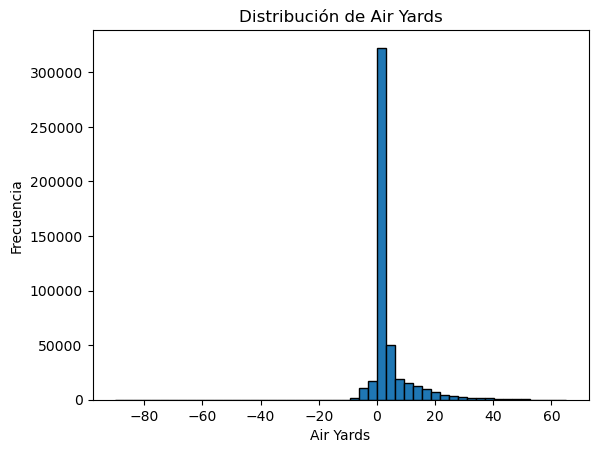

In [25]:
plt.hist(regular_ssn['air_yards'], bins=50, edgecolor='black')
plt.title("Distribución de Air Yards")
plt.xlabel("Air Yards")
plt.ylabel("Frecuencia")
plt.show()

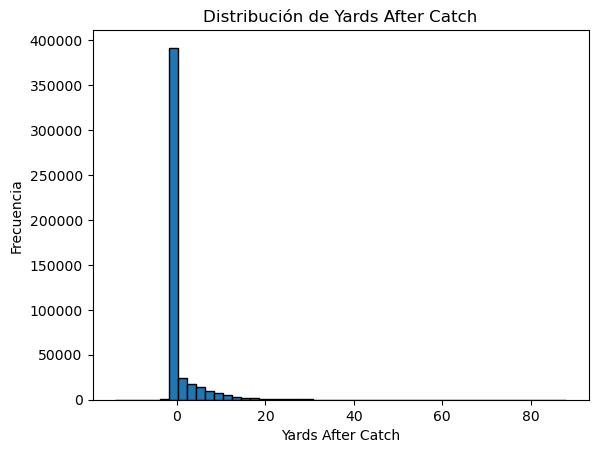

In [26]:
plt.hist(regular_ssn['yards_after_catch'], bins=50, edgecolor='black')
plt.title("Distribución de Yards After Catch")
plt.xlabel("Yards After Catch")
plt.ylabel("Frecuencia")
plt.show()

Aqui podemos enfocarnos un poco mas en pases, quitando jugadas que fueron especiales o run, asi que podemos filtrar

In [27]:
pass_play = regular_ssn[regular_ssn['pass_attempt']== True]

In [28]:
pass_play

,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,incomplete_pass,pass_attempt,pass_touchdown,complete_pass,receiving_yards,passer,receiver,pass,pass_oe,offense_formation,offense_personnel,n_offense,time_to_throw,route,pass_length_0,pass_length_deep,pass_length_short,pass_location_0,pass_location_left,pass_location_middle,pass_location_right
2,True,False,False,False,3,0,False,True,False,True,3,J.Flacco,K.Juszczyk,True,54.351910,0,0,0,0.0,0,False,False,True,False,True,False,False
4,True,False,False,False,4,6,False,True,False,True,10,J.Flacco,S.Smith,True,3.146732,0,0,0,0.0,0,False,False,True,False,False,True,False
6,True,False,False,False,2,1,False,True,False,True,3,J.Flacco,S.Smith,True,51.014824,0,0,0,0.0,0,False,False,True,False,False,False,True
7,True,False,False,False,9,0,True,True,False,False,0,J.Flacco,K.Aiken,True,2.069181,0,0,0,0.0,0,False,False,True,False,False,True,False
10,True,False,False,False,8,0,False,True,False,True,8,P.Manning,D.Thomas,True,37.146790,0,0,0,0.0,0,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504208,True,False,False,False,3,14,False,True,False,True,17,C.Ward,T.Spears,True,22.348452,0,0,0,0.0,0,False,False,True,False,False,True,False
504210,True,False,False,False,18,4,False,True,False,True,22,C.Ward,G.Helm,True,26.856487,0,0,0,0.0,0,False,True,False,False,False,False,True
504211,True,False,False,False,-5,4,False,True,False,True,-1,C.Ward,T.Spears,True,22.373831,0,0,0,0.0,0,False,False,True,False,False,False,True
504213,True,False,False,False,3,0,True,True,False,False,0,C.Ward,E.Ayomanor,True,22.654366,0,0,0,0.0,0,False,False,True,False,False,False,True


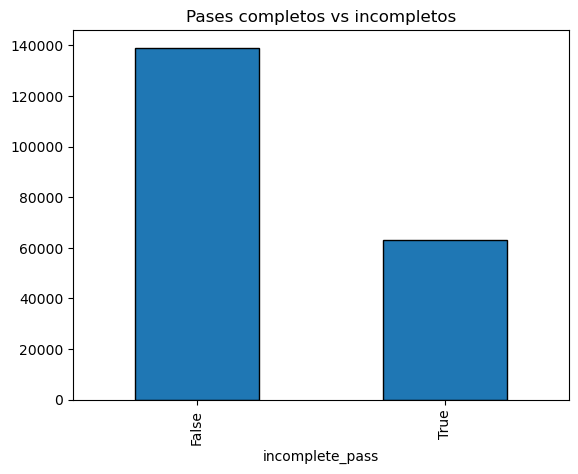

In [29]:
pass_play['incomplete_pass'].value_counts().plot.bar(edgecolor='black')
plt.title("Pases completos vs incompletos")
plt.show()

Aqui vemos que es mas comun que un intento a pase termine en un pase exitoso, aqui conviene separar por jugadores de interes para poder comparar rendimiento.

In [30]:
brady_pp = pass_play[pass_play['passer']=='T.Brady']
flacco_pp = pass_play[pass_play['passer']=='J.Flacco']
allen_pp = pass_play[pass_play['passer']=='J.Allen']
mahomes_pp = pass_play[pass_play['passer']=='P.Mahomes']
burrow_pp = pass_play[pass_play['passer']=='J.Burrow']
lamar_pp = pass_play[pass_play['passer']=='L.Jackson']
manning_pp = pass_play[pass_play['passer']=='P.Manning']

lamar_pp

,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,incomplete_pass,pass_attempt,pass_touchdown,complete_pass,receiving_yards,passer,receiver,pass,pass_oe,offense_formation,offense_personnel,n_offense,time_to_throw,route,pass_length_0,pass_length_deep,pass_length_short,pass_location_0,pass_location_left,pass_location_middle,pass_location_right
143234,True,False,False,False,10,0,True,True,False,False,0,L.Jackson,W.Snead,True,51.209362,EMPTY,"2 QB, 0 RB, 1 TE, 3 WR",11,4.838,IN,False,False,True,False,False,False,True
143330,True,False,False,False,0,0,False,True,False,False,0,L.Jackson,0,True,4.191172,SHOTGUN,"1 RB, 1 TE, 3 WR",11,0.000,0,True,False,False,True,False,False,False
143353,True,False,False,False,14,0,True,True,False,False,0,L.Jackson,0,True,62.483658,SINGLEBACK,"1 RB, 3 TE, 1 WR",11,6.418,0,False,False,True,False,False,False,True
143354,True,False,False,False,14,0,True,True,False,False,0,L.Jackson,M.Andrews,True,12.033379,SHOTGUN,"1 RB, 1 TE, 3 WR",11,3.070,CROSS,False,False,True,False,True,False,False
143374,True,False,False,False,13,11,False,True,False,True,24,L.Jackson,M.Williams,True,22.417826,SHOTGUN,"1 RB, 2 TE, 2 WR",11,3.170,IN,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491967,True,False,False,False,20,0,True,True,False,False,0,L.Jackson,D.Hopkins,True,2.989572,0,0,0,0.000,0,False,True,False,False,True,False,False
491968,True,False,False,False,6,0,False,True,False,True,6,L.Jackson,M.Andrews,True,4.773813,0,0,0,0.000,0,False,False,True,False,True,False,False
491983,True,False,False,False,19,5,False,True,False,True,24,L.Jackson,R.Bateman,True,45.866776,0,0,0,0.000,0,False,True,False,False,False,False,True
491984,True,False,False,False,12,3,False,True,False,True,15,L.Jackson,Z.Flowers,True,43.584000,0,0,0,0.000,0,False,False,True,False,False,True,False


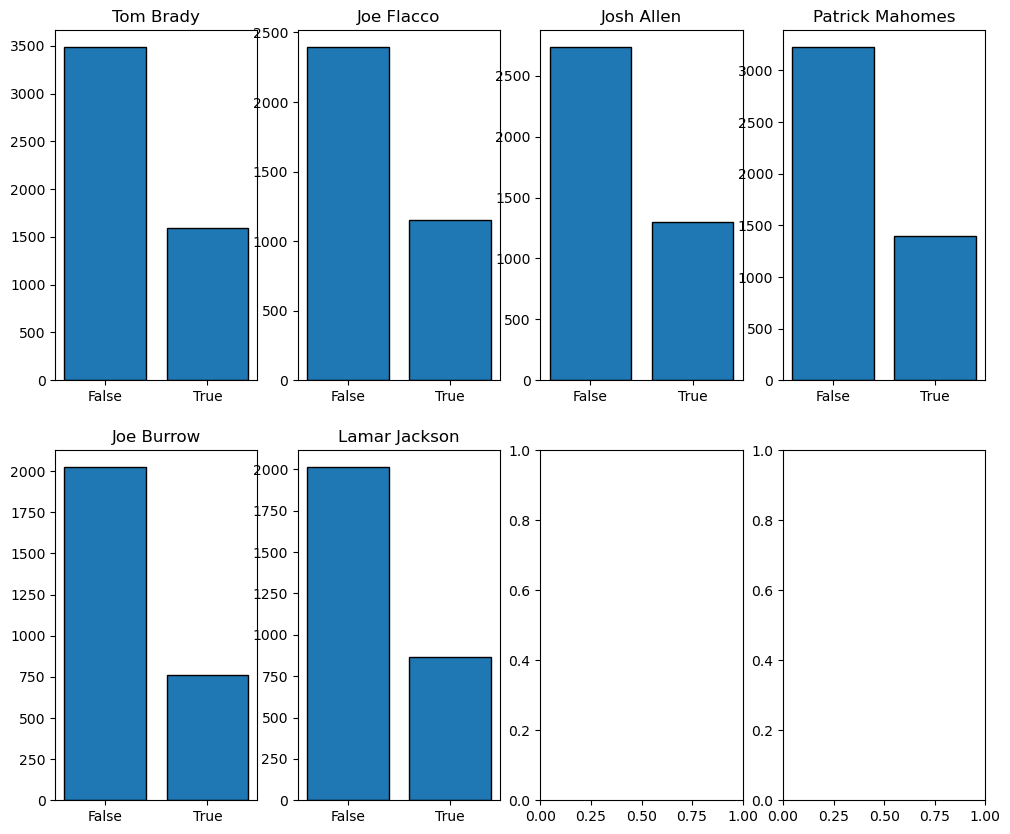

In [31]:
qbs = [
    (brady_pp, "Tom Brady"),
    (flacco_pp, "Joe Flacco"),
    (allen_pp, "Josh Allen"),
    (mahomes_pp, "Patrick Mahomes"),
    (burrow_pp, "Joe Burrow"),
    (lamar_pp, "Lamar Jackson")
]
fig, axes = plt.subplots(2, 4, figsize=(12, 10))
axes = axes.flatten()

for i, (qb_data, qb_name) in enumerate(qbs):
    conteo = qb_data['incomplete_pass'].value_counts()
    axes[i].bar(conteo.index.astype(str), conteo.values, edgecolor='black')
    axes[i].set_title(qb_name)

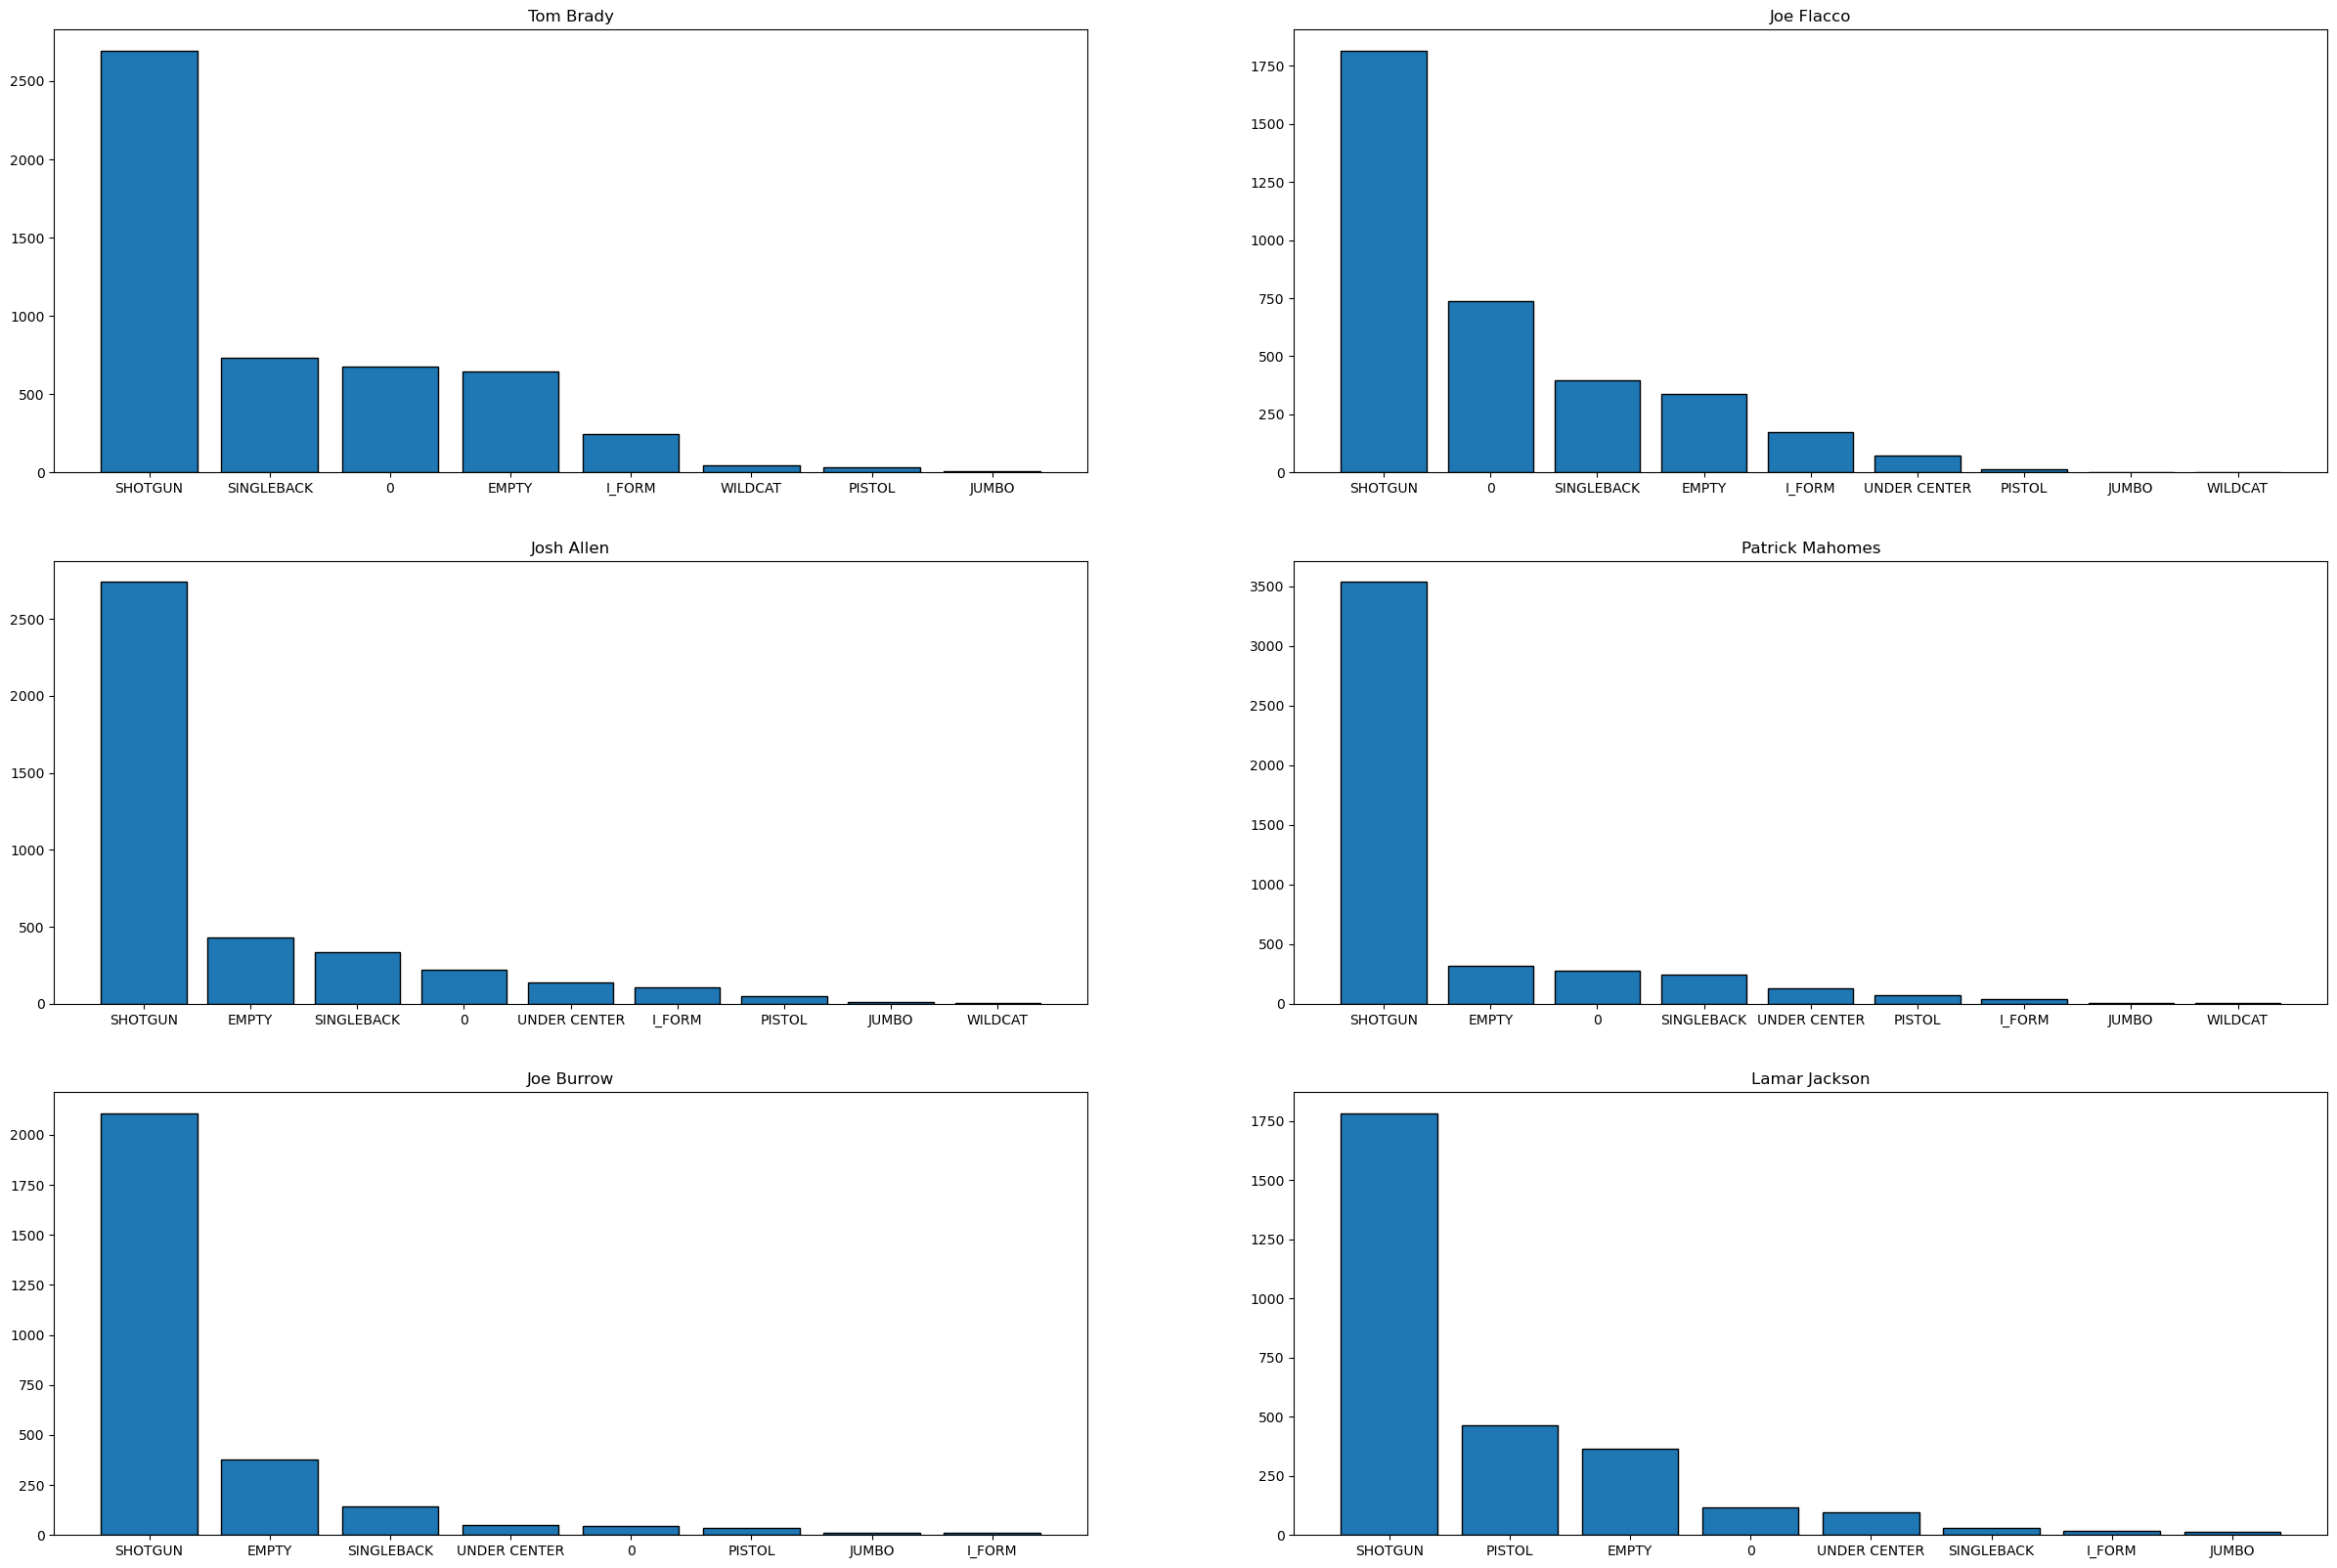

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(30, 20))
axes = axes.flatten()

for i, (qb_data, qb_name) in enumerate(qbs):
    conteo = qb_data['offense_formation'].value_counts()
    axes[i].bar(conteo.index.astype(str), conteo.values, edgecolor='black')
    axes[i].set_title(qb_name)

Podemos ver las jugadas favoritas por QB, o al menos las que mas le funcionaba, podemos hacer igual un grafico que enseñe a sus mejores receptores

In [33]:
#Revisar Funcion, 
def tabla_targets(df_qb, qb_name, min_targets=10, top=None):
    vc = df_qb['receiver'].value_counts()
    total = int(vc.sum())
    tabla = (vc.rename('targets').to_frame()
               .assign(pct=lambda t: (t['targets']/total).round(4))
               .assign(pct_acum=lambda t: t['pct'].cumsum().round(4)))
    if min_targets:
        tabla = tabla[tabla['targets'] >= min_targets]
    if top:
        tabla = tabla.head(top)
    tabla.index.name = f'{qb_name} – receiver'
    return tabla
    
tablas = {name: tabla_targets(df, name, min_targets=10) for df, name in qbs}
tabla_multi = pd.concat(tablas)  # índice: (QB, receiver)
tabla_multi.head(3)

targets     pct  pct_acum
Tom Brady R.Gronkowski      498  0.0979    0.0979
          J.Edelman         481  0.0946    0.1925
          J.White           409  0.0804    0.2729

In [34]:
tabla_multi.to_csv("targets_por_qb.csv", encoding="utf-8")

### Targets
* Es el número total de pases lanzados hacia un receptor específico (también llamado targets en NFL).
### Pct (Porcentaje)
* Es el porcentaje de targets de ese receptor respecto al total de pases de ese QB.
### Pct acum (Porcentaje acumulado)
* Es el acumulado de pct conforme bajas en la lista de receptores.

In [35]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Index(['qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'air_yards',
       'yards_after_catch', 'incomplete_pass', 'pass_attempt',
       'pass_touchdown', 'complete_pass', 'receiving_yards', 'passer',
       'receiver', 'pass', 'pass_oe', 'offense_formation', 'offense_personnel',
       'n_offense', 'time_to_throw', 'route', 'pass_length_0',
       'pass_length_deep', 'pass_length_short', 'pass_location_0',
       'pass_location_left', 'pass_location_middle', 'pass_location_right'],
      dtype='object')


<function matplotlib.pyplot.show(close=None, block=None)>

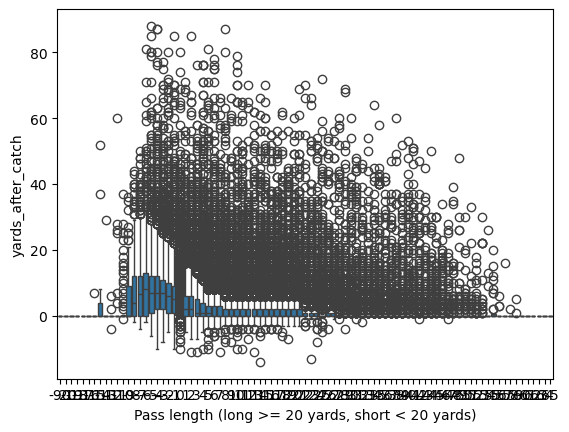

In [36]:
import seaborn as sns
print(pass_play.columns)
qb_boxplot = sns.boxplot(data=pass_play, x="air_yards", y="yards_after_catch");
qb_boxplot.set(
xlabel="Pass length (long >= 20 yards, short < 20 yards)")
plt.show

Aqui podemos ver que los diagramas de caja estan muy juntoss, lo que podemos hacer es separarlos para ver su distribucion

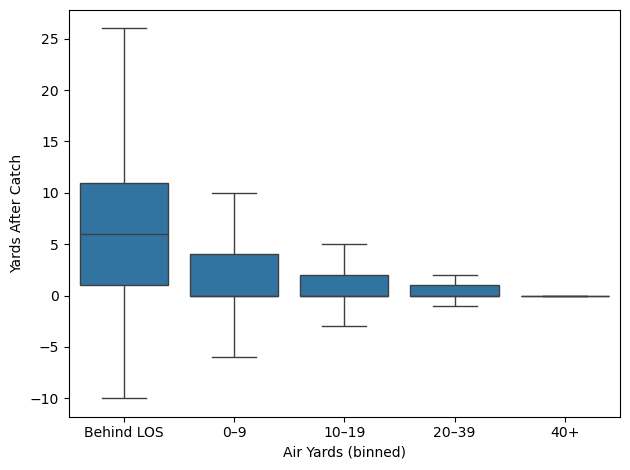

In [37]:
df = pass_play.copy()

bins   = [-10, 0, 10, 20, 40, 100]
labels = ['Behind LOS', '0–9', '10–19', '20–39', '40+']
df['air_bin'] = pd.cut(df['air_yards'], bins=bins, labels=labels, right=False)

ax = sns.boxplot(data=df, x='air_bin', y='yards_after_catch', showfliers=False)
ax.set(
    xlabel='Air Yards (binned)', 
    ylabel='Yards After Catch'
)
plt.tight_layout()
plt.show()

Aqui podemos ver como se concentran los datos, y tambien que cuando hay perdida de yaras por aire, tienen mas ganancia de yardas despues de atrapar el balon, siendo esto porque son jugadas que pasan a los laterales ya que no tienen algun receptor libre

Ahora volveremos a extraer columnas de nuestro dataset original, esto para poder darle un enfoque mas enfocado en la ofensiva, tambien teniendo el objetivo que nos ayude a apostar

In [105]:
cols = [
    'season','season_type','week','time_of_day','stadium','weather',
    'div_game','surface','home_coach','away_coach','drive','play','play_type','play_deleted',
    'touchdown','rush_touchdown','pass_touchdown','return_touchdown',
    'field_goal_attempt','field_goal_result','extra_point_attempt',
    'extra_point_result','extra_point_prob','two_point_attempt',
    'two_point_conv_result','two_point_conversion_prob',
    'safety','safety_prob','interception','fumble','sack',
    'out_of_bounds','touchback','aborted_play','no_huddle',
    'special_teams_play','offense_formation',
    'passer','pass','pass_length','pass_location',
    'receiver','yards_after_catch','route','time_to_throw',
    'qb_dropback','qb_kneel','qb_spike','qb_scramble',
    'air_yards','incomplete_pass','complete_pass','passing_yards','home_team','away_team','posteam'
]
OfensiveData = data[cols]
OfensiveData

,season,season_type,week,time_of_day,stadium,weather,div_game,surface,home_coach,away_coach,drive,play,play_type,play_deleted,touchdown,rush_touchdown,pass_touchdown,return_touchdown,field_goal_attempt,field_goal_result,extra_point_attempt,extra_point_result,extra_point_prob,two_point_attempt,two_point_conv_result,two_point_conversion_prob,safety,safety_prob,interception,fumble,sack,out_of_bounds,touchback,aborted_play,no_huddle,special_teams_play,offense_formation,passer,pass,pass_length,pass_location,receiver,yards_after_catch,route,time_to_throw,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,incomplete_pass,complete_pass,passing_yards,home_team,away_team,posteam
0,2015,REG,1,None,Empower Field at Mile High,"Partly Sunny Temp: 88° F, Humidity: 8%, Wind: ...",0,grass,Gary Kubiak,John Harbaugh,NaN,0.0,None,0.0,NaN,NaN,NaN,NaN,NaN,None,NaN,None,0.0,NaN,None,0.0,NaN,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,None,0.0,None,None,None,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,DEN,BAL,None
1,2015,REG,1,2015-09-13T20:25:26Z,Empower Field at Mile High,"Partly Sunny Temp: 88° F, Humidity: 8%, Wind: ...",0,grass,Gary Kubiak,John Harbaugh,1.0,0.0,kickoff,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.003269,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,None,0.0,None,None,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,DEN,BAL,BAL
2,2015,REG,1,2015-09-13T20:26:09Z,Empower Field at Mile High,"Partly Sunny Temp: 88° F, Humidity: 8%, Wind: ...",0,grass,Gary Kubiak,John Harbaugh,1.0,1.0,pass,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.003269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,J.Flacco,1.0,short,left,K.Juszczyk,0.0,NaN,NaN,1.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0,DEN,BAL,BAL
3,2015,REG,1,2015-09-13T20:26:36Z,Empower Field at Mile High,"Partly Sunny Temp: 88° F, Humidity: 8%, Wind: ...",0,grass,Gary Kubiak,John Harbaugh,1.0,1.0,run,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.003409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None,0.0,None,None,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,DEN,BAL,BAL
4,2015,REG,1,2015-09-13T20:27:17Z,Empower Field at Mile High,"Partly Sunny Temp: 88° F, Humidity: 8%, Wind: ...",0,grass,Gary Kubiak,John Harbaugh,1.0,1.0,pass,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.003518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,J.Flacco,1.0,short,middle,S.Smith,6.0,NaN,NaN,1.0,0.0,0.0,0.0,4.0,0.0,1.0,10.0,DEN,BAL,BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504219,2025,REG,8,2025-10-26T23:19:56Z,Lucas Oil Stadium,"Temp: 52° F, Humidity: 53%, Wind: E 2 mph",1,,Shane Steichen,Brian Callahan,21.0,1.0,pass,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.001441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,R.Leonard,1.0,short,right,A.Mitchell,NaN,NaN,NaN,1.0,0.0,0.0,0.0,4.0,1.0,0.0,NaN,IND,TEN,IND
504220,2025,REG,8,2025-10-26T23:20:38Z,Lucas Oil Stadium,"Temp: 52° F, Humidity: 53%, Wind: E 2 mph",1,,Shane Steichen,Brian Callahan,21.0,0.0,punt,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.001510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,None,0.0,None,None,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,IND,TEN,IND
504221,2025,REG,8,2025-10-26T23:21:33Z,Lucas Oil Stadium,"Temp: 52° F, Humidity: 53%, Wind: E 2 mph",1,,Shane Steichen,Brian Callahan,22.0,1.0,run,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None,0.0,None,None,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,IND,TEN,TEN
504222,2025,REG,8,2025-10-26T23:22:07Z,Lucas Oil Stadium,"Temp: 52° F, Humidity: 53%, Wind: E 2 mph",1,,Shane Steichen,Brian Callahan,22.0,1.0,run,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,0.0,None,0.0,0.0,0.000496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None,0.0,None,None,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,IND,TEN,TEN


In [106]:
OfensiveData['time_to_throw'].unique()

array([  nan, 2.404, 2.093, ..., 6.38 , 8.22 , 8.8  ], dtype=float32)

* grass / grass → césped natural (nota: el segundo trae espacio al final).

* fieldturf → césped artificial marca FieldTurf (infill de caucho/arena).

* a_turf → césped artificial marca A-Turf.

* matrixturf → césped artificial marca Matrix Turf (de Hellas, ej. AT&T Stadium).

* astroplay → césped artificial marca AstroPlay (vieja generación, infilled).

* sportturf → césped artificial marca Sporturf.

* astroturf → césped artificial marca AstroTurf (las primeras/antiguas versiones eran tipo “carpeta”, hoy hay versiones infilled).

* '' (cadena vacía) → desconocido/na.

Vamos a limpiar los datos, convertir si es necesario y llenar espacios vacios

In [107]:
import numpy as np
import pandas as pd

df = OfensiveData.copy()

# -------------------------
# 1) Quitamos espacios en blanco al inicio y al final de cada texto
# -------------------------
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace({"None": np.nan, "none": np.nan, "NaN": np.nan, "nan": np.nan})

# -------------------------
# 2) Convertimos columnas binarias
# -------------------------
bin_cols = ['play','play_deleted','touchdown','rush_touchdown','pass_touchdown','return_touchdown',
            'field_goal_attempt','extra_point_attempt','two_point_attempt','safety','interception','fumble',
            'sack','out_of_bounds','touchback','aborted_play','no_huddle','special_teams_play','pass',
            'qb_dropback','qb_kneel','qb_spike','qb_scramble','incomplete_pass','complete_pass']

missing_bin = [c for c in bin_cols if c not in df.columns]
if missing_bin:
    print("Advertencia - no están estas columnas binarias:", missing_bin)

present_bin = [c for c in bin_cols if c in df.columns]
df[present_bin] = df[present_bin].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# -------------------------
# 3) Formateo de fechas, se convierte de texto a formato de fecha 
# -------------------------
# Cambia los nombres si los tuyos son distintos:
possible_dt = ["game_date", "game_datetime", "time_of_day"]
for c in possible_dt:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# -------------------------
# 4) Superficie y clima (normalización + categorías)
# -------------------------
if "surface" in df.columns:
    df["surface"] = df["surface"].str.lower().str.replace(r"\s+", " ", regex=True)
    surface_map = {
        "natural grass":"grass","grass":"grass","kentucky bluegrass":"grass","bermuda grass":"grass",
        "fieldturf":"turf","artificial":"turf","turf":"turf","astro turf":"turf","synthetic":"turf"
    }
    df["surface_norm"] = df["surface"].map(surface_map).fillna("other")

if "weather" in df.columns:
    w = df["weather"].str.lower()
    def bucket_weather(x):
        if pd.isna(x): return "unknown"
        if any(k in x for k in ["rain","showers","drizzle"]): return "rain"
        if any(k in x for k in ["snow","flurries","sleet"]): return "snow"
        if any(k in x for k in ["wind","breez"]): return "wind"
        if any(k in x for k in ["sun","clear","fair"]): return "clear"
        if any(k in x for k in ["cloud","overcast","fog","mist"]): return "cloudy"
        return "other"
    df["weather_bucket"] = w.apply(bucket_weather)

# -------------------------
# 5) Campos de pase: categorías limpias
# -------------------------
for c in ["offense_formation","pass_length","pass_location","route"]:
    if c in df.columns:
        df[c] = df[c].str.lower().replace({"": np.nan})

# Top-N categorías para 'route' (evita demasiadas dummies)
if "route" in df.columns:
    topN = 10
    top_routes = df["route"].value_counts().head(topN).index
    df["route_top"] = np.where(df["route"].isin(top_routes), df["route"], "other_or_nan")

# -------------------------
# 6) Variables numéricas con posibles strings
# -------------------------
num_like = ["yards_after_catch","air_yards","offense_players"]
for c in num_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Imputación simple (mediana) para numéricos
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# -------------------------
# 7) Dummies de categóricas relevantes
# -------------------------
cat_to_dummify = []
for c in ["surface_norm","weather_bucket","offense_formation","pass_length","pass_location","route_top"]:
    if c in df.columns:
        cat_to_dummify.append(c)

df = pd.get_dummies(df, columns=cat_to_dummify, drop_first=True)

OfensiveData_clean = df
print("Shape final:", OfensiveData_clean.shape)


Shape final: (504224, 78)


In [108]:
OfensiveData_clean
print(OfensiveData_clean.isna().sum())

season                      0
season_type                 0
week                        0
time_of_day            156475
stadium                     0
                        ...  
route_top_out               0
route_top_post              0
route_top_quick out         0
route_top_screen            0
route_top_slant             0
Length: 78, dtype: int64


In [109]:
valores_unicos = OfensiveData_clean['receiver'].unique()

In [110]:
OfensiveData_clean.columns

Index(['season', 'season_type', 'week', 'time_of_day', 'stadium', 'weather',
       'div_game', 'surface', 'home_coach', 'away_coach', 'drive', 'play',
       'play_type', 'play_deleted', 'touchdown', 'rush_touchdown',
       'pass_touchdown', 'return_touchdown', 'field_goal_attempt',
       'field_goal_result', 'extra_point_attempt', 'extra_point_result',
       'extra_point_prob', 'two_point_attempt', 'two_point_conv_result',
       'two_point_conversion_prob', 'safety', 'safety_prob', 'interception',
       'fumble', 'sack', 'out_of_bounds', 'touchback', 'aborted_play',
       'no_huddle', 'special_teams_play', 'passer', 'pass', 'receiver',
       'yards_after_catch', 'route', 'time_to_throw', 'qb_dropback',
       'qb_kneel', 'qb_spike', 'qb_scramble', 'air_yards', 'incomplete_pass',
       'complete_pass', 'passing_yards', 'home_team', 'away_team', 'posteam',
       'surface_norm_other', 'surface_norm_turf', 'weather_bucket_snow',
       'weather_bucket_unknown', 'weather_bucket_w

In [111]:
print(nan_routes_df['play_type'].value_counts(dropna=False))

NameError: name 'nan_routes_df' is not defined

Aqui vemos que aunque route, tengamos muchos Na, vemos que mas del 62% de nuestro dataset nos enfrentamos con run, que igual haiendo la comparacion, sigue habiendo una mas abundancia de pases que de carreras en nuestro dataset.

Ahora vamos a analizar los dos siguientes qb del partido de Chiefs vs Commanders

In [112]:
pbp_py_p_s_corregido = \
    OfensiveData_clean.query("play_deleted == 0 and play_type == 'pass' and sack == 0 and incomplete_pass == 0 and interception == 0") \
    .groupby(["passer", "season", "week", "home_team", "away_team"]) \
    .agg({
        "passing_yards": ["sum", "count"],
        "air_yards": ["sum", "count"]
        
    })

In [113]:
lista_jugadores = ["P.Mahomes", "M.Mariota"] 
equipo_1 = "KC"
equipo_2 = "WAS"

stats_enfrentamiento = pbp_py_p_s_corregido.query(
    "passer in @lista_jugadores and " +
    "((home_team == @equipo_1 and away_team == @equipo_2) or " +
    " (home_team == @equipo_2 and away_team == @equipo_1))"
)

print(stats_enfrentamiento)

                                          passing_yards       air_yards      
                                                    sum count       sum count
passer    season week home_team away_team                                    
P.Mahomes 2021   6    WAS       KC                397.0    32     230.0    32


Lo cual realmente es muy cercano, ya que el registro de Mahomes en ese partido fue de 

In [114]:
lista_jugadores = ["M.Mariota"]  
equipo_rival = "KC"

stats_mariota_vs_kc = pbp_py_p_s_corregido.query(
    "passer in @lista_jugadores and " +
    "(home_team == @equipo_rival or away_team == @equipo_rival)"
)

print(stats_mariota_vs_kc)

                                          passing_yards       air_yards      
                                                    sum count       sum count
passer    season week home_team away_team                                    
M.Mariota 2016   15   KC        TEN               250.0    20     155.0    20
          2017   18   KC        TEN               223.0    21     101.0    21


In [115]:
print(OfensiveData_clean.incomplete_pass)

0         0
1         0
2         0
3         0
4         0
         ..
504219    1
504220    0
504221    0
504222    0
504223    0
Name: incomplete_pass, Length: 504224, dtype: int64


In [116]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [139]:
print("Paso 1: Creando estadísticas defensivas por juego...")
# Usamos play_type == 'pass' para incluir sacks en las yardas permitidas
pbp_pass_plays = OfensiveData_clean.query("play_deleted == 0 and play_type == 'pass'")

# Creamos la columna 'defteam' (el equipo defensivo)
pbp_pass_plays['defteam'] = np.where(
    pbp_pass_plays['posteam'] == pbp_pass_plays['home_team'], 
    pbp_pass_plays['away_team'], 
    pbp_pass_plays['home_team']
)

# Agrupamos por juego para CADA DEFENSA
df_def_stats = pbp_pass_plays.groupby(
    ['defteam', 'season', 'week']
).agg(
    yards_allowed_game=('passing_yards', 'sum'),
    tds_allowed_game=('pass_touchdown', 'sum'),
    ints_made_game=('interception', 'sum') 
).reset_index()


# --- PASO 2: CREAR STATS OFENSIVAS (POR JUEGO) ---
print("Paso 2: Creando estadísticas ofensivas por juego...")
# Filtramos solo por INTENTOS de pase (sin sacks), como descubrimos
pbp_pass_attempts = OfensiveData_clean.query(
    "play_deleted == 0 and play_type == 'pass' and sack == 0"
)

# Agrupamos por juego para CADA PASADOR
df_agg_offense = pbp_pass_attempts.groupby(
    ['passer', 'posteam', 'season', 'week', 'home_team', 'away_team']
).agg(
    passing_yards_game=('passing_yards', 'sum'),
    pass_attempts_game=('play_type', 'count')
).reset_index()

# Añadimos el oponente y si es local
df_agg_offense['X_opponent'] = np.where(
    df_agg_offense['posteam'] == df_agg_offense['home_team'],
    df_agg_offense['away_team'],
    df_agg_offense['home_team']
)
df_agg_offense['X_is_home'] = np.where(
    df_agg_offense['posteam'] == df_agg_offense['home_team'], 1, 0
)


# --- PASO 3: CREAR INFO DEL JUEGO (CLIMA Y SUPERFICIE LIMPIOS) ---
print("Paso 3: Creando y limpiando info del juego (clima, superficie)...")
df_game_info = OfensiveData_clean.groupby(
    ['season', 'week', 'home_team', 'away_team']
).agg(
    surface_raw=('surface', 'first'),
    weather_raw=('weather', 'first')
).reset_index()

# Limpieza de Superficie (tu mapa original)
surface_map = {
    "natural grass":"grass","grass":"grass","kentucky bluegrass":"grass","bermuda grass":"grass",
    "fieldturf":"turf","artificial":"turf","turf":"turf","astro turf":"turf","synthetic":"turf"
}
df_game_info["surface_norm"] = df_game_info["surface_raw"].str.lower().map(surface_map).fillna("other")

# Limpieza de Clima (tu función original)
def bucket_weather(x):
    if pd.isna(x): return "unknown"
    x = str(x).lower()
    if any(k in x for k in ["dome","indoor"]): return "dome" # Revisar domo primero
    if any(k in x for k in ["rain","showers","drizzle"]): return "rain"
    if any(k in x for k in ["snow","flurries","sleet"]): return "snow"
    if any(k in x for k in ["wind","breez"]): return "wind"
    if any(k in x for k in ["sun","clear","fair"]): return "clear"
    if any(k in x for k in ["cloud","overcast","fog","mist"]): return "cloudy"
    return "other"

df_game_info["weather_bucket"] = df_game_info["weather_raw"].apply(bucket_weather)


# --- PASO 4: UNIR TODO EN UN DATAFRAME MAESTRO ---
print("Paso 4: Uniendo todos los DataFrames...")
# Merge Ofensiva + Defensa
df_master = pd.merge(
    df_agg_offense,
    df_def_stats,
    left_on=['X_opponent', 'season', 'week'],
    right_on=['defteam', 'season', 'week'],
    how='left'
)

# Merge (Of+Def) + Game Info (limpio)
df_master_final = pd.merge(
    df_master,
    df_game_info.drop(columns=['surface_raw', 'weather_raw']), # Quitamos las 'raw'
    on=['season', 'week', 'home_team', 'away_team'],
    how='left'
)


# --- PASO 5: INGENIERÍA DE FEATURES (PROMEDIOS MÓVILES) ---
print("Paso 5: Creando features de promedios móviles...")

# --- 1. Features Ofensivas (por pasador) ---
df_master_final = df_master_final.sort_values(by=['passer', 'season', 'week'])
g_passer = df_master_final.groupby(['passer', 'season']) # Agrupamos por temporada

# .shift(1) para usar solo datos pasados
# Rolling = Forma Reciente
df_master_final['X_passer_avg_yards_L3'] = g_passer['passing_yards_game'].shift(1).rolling(3, min_periods=1).mean()
# Expanding = Calidad de la Temporada
df_master_final['X_passer_avg_yards_Season'] = g_passer['passing_yards_game'].shift(1).expanding(min_periods=1).mean()


# --- 2. Features Defensivas (por oponente) ---
df_master_final = df_master_final.sort_values(by=['defteam', 'season', 'week'])
g_defteam = df_master_final.groupby(['defteam', 'season']) # Agrupamos por temporada

# Rolling = Forma Reciente
df_master_final['X_def_avg_yards_allowed_L3'] = g_defteam['yards_allowed_game'].shift(1).rolling(3, min_periods=1).mean()
# Expanding = Calidad de la Temporada
df_master_final['X_def_avg_yards_allowed_Season'] = g_defteam['yards_allowed_game'].shift(1).expanding(min_periods=1).mean()


# --- ¡NUEVO PASO 5.5: CREAR FEATURES DE ENFRENTAMIENTO! ---
print("Paso 5.5: Creando features de 'mismatch' (enfrentamiento)...")

# Esta feature mide la "calidad real" del QB vs. la "calidad real" de la defensa
df_master_final['X_pass_vs_def_Season'] = \
    df_master_final['X_passer_avg_yards_Season'] - df_master_final['X_def_avg_yards_allowed_Season']

# Esta feature mide la "forma reciente" del QB vs. la "forma reciente" de la defensa
df_master_final['X_pass_vs_def_L3'] = \
    df_master_final['X_passer_avg_yards_L3'] - df_master_final['X_def_avg_yards_allowed_L3']

# --- PASO 6 (MODIFICADO): PREPARAR DATOS PARA EL MODELO (Versión 5) ---
print("Paso 6 (Versión 5): Forzando al modelo a usar SOLO features de 'enfrentamiento'...")

# Lista final de features que usaremos
features = [
    # --- PROMEDIOS CRUDOS ELIMINADOS ---
    # 'X_passer_avg_yards_L3',
    # 'X_passer_avg_yards_Season',
    # 'X_def_avg_yards_allowed_L3',
    # 'X_def_avg_yards_allowed_Season',
    
    # --- SOLO MANTENEMOS LAS FEATURES DE 'MISMATCH' ---
    'X_pass_vs_def_Season', # Calidad de temporada del QB vs. Defensa
    'X_pass_vs_def_L3',     # Forma reciente del QB vs. Defensa
    
    # --- MANTENEMOS EL CONTEXTO ---
    'X_is_home',
    'week',
    'X_opponent',
    'surface_norm',
    'weather_bucket'
]
target = 'passing_yards_game'

# 1. Limpiamos NaNs (igual que antes)
df_model = df_master_final.dropna(subset=features)

# 2. Filtramos por datos recientes (¡MANTENEMOS ESTO, FUE UNA BUENA IDEA!)
df_model_reciente = df_model[df_model['season'] >= 2021]

# 3. Convertimos categóricas en números
X = pd.get_dummies(
    df_model_reciente[features], 
    columns=['X_opponent', 'surface_norm', 'weather_bucket'],
    drop_first=True
)
y = df_model_reciente[target]

# 4. Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Nuevos datos de entrenamiento: {X_train.shape}")
print(f"Nuevos datos de prueba: {X_test.shape}")


# --- PASO 7 (MODIFICADO): ENTRENAR Y EVALUAR (Versión 5) ---
print("\n--- PASO 7: ENTRENANDO EL RANDOM FOREST (Versión 5) ---")

rf_model_v5 = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

rf_model_v5.fit(X_train, y_train)
print("¡Modelo entrenado!")

# Evaluar el modelo
predictions = rf_model_v5.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS DEL MODELO (Versión 5) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features fueron más importantes
importances = pd.Series(
    rf_model_v5.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (Versión 5) ---")
print(importances.head(15))

# --- PASO 7: ENTRENAR Y EVALUAR (Versión 4) ---
print("\n--- PASO 7: ENTRENANDO EL RANDOM FOREST (Versión 4) ---")

rf_model_v4 = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

rf_model_v4.fit(X_train, y_train)
print("¡Modelo entrenado!")

# Evaluar el modelo
predictions = rf_model_v4.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS DEL MODELO (Versión 4) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features fueron más importantes
importances = pd.Series(
    rf_model_v4.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (Versión 4) ---")
print(importances.head(15))
# Evaluar el modelo
predictions = rf_model_v4.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS DEL MODELO (Versión 4) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features fueron más importantes
importances = pd.Series(
    rf_model_v4.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (Versión 4) ---")
print(importances.head(15))

Paso 1: Creando estadísticas defensivas por juego...
Paso 2: Creando estadísticas ofensivas por juego...
Paso 3: Creando y limpiando info del juego (clima, superficie)...
Paso 4: Uniendo todos los DataFrames...
Paso 5: Creando features de promedios móviles...
Paso 5.5: Creando features de 'mismatch' (enfrentamiento)...
Paso 6 (Versión 5): Forzando al modelo a usar SOLO features de 'enfrentamiento'...
Nuevos datos de entrenamiento: (2405, 41)
Nuevos datos de prueba: (602, 41)

--- PASO 7: ENTRENANDO EL RANDOM FOREST (Versión 5) ---
¡Modelo entrenado!

--- RESULTADOS DEL MODELO (Versión 5) ---
Error Absoluto Medio (MAE): 93.67 yardas

--- IMPORTANCIA DE LAS FEATURES (Versión 5) ---
X_pass_vs_def_L3          0.545471
X_pass_vs_def_Season      0.142366
week                      0.080702
surface_norm_turf         0.016600
surface_norm_other        0.014603
X_is_home                 0.013167
X_opponent_MIN            0.010528
X_opponent_BUF            0.010164
X_opponent_DAL            0.009

In [140]:
# --- 1. Definir los datos del partido de HOY ---
# (Basado en la búsqueda: es Semana 8, 2025, WAS @ KC)
# (Superficie: Arrowhead es Bermuda grass, que en tu mapa es 'grass')
# (Clima: Nublado y lluvia ligera esta noche, así que usaremos 'rain' y 'cloudy')

partido_info = {
    'season': 2025,
    'week': 8,
    'X_opponent_Mahomes': 'WAS',
    'X_opponent_Mariota': 'KC',
    'surface_norm': 'grass',       # Arrowhead es Bermuda grass
    'weather_bucket': 'rain'     # Pronóstico de lluvia ligera esta noche
}

# --- 2. Encontrar los últimos promedios de tu DataFrame ---
# (Usamos .iloc[-1] para tomar la última fila/último juego registrado)

# Filtramos por temporada 2025 para obtener la data más reciente
df_2025 = df_master_final[df_master_final['season'] == 2025]

# --- Stats de Mahomes (Ofensiva) ---
stats_mahomes = df_2025[
    df_2025['passer'] == 'P.Mahomes'
].sort_values(by='week').iloc[-1]

# --- Stats de Mariota (Ofensiva) ---
stats_mariota = df_2025[
    df_2025['passer'] == 'M.Mariota'
].sort_values(by='week').iloc[-1]

# --- Stats de la Defensa de WAS ---
stats_def_was = df_2025[
    df_2025['defteam'] == 'WAS'
].sort_values(by='week').iloc[-1]

# --- Stats de la Defensa de KC ---
stats_def_kc = df_2025[
    df_2025['defteam'] == 'KC'
].sort_values(by='week').iloc[-1]


# --- 3. Construir la fila de predicción para Mahomes ---
pred_mahomes = {
    # --- Features de Enfrentamiento (las más importantes) ---
    'X_pass_vs_def_Season': stats_mahomes['X_passer_avg_yards_Season'] - stats_def_was['X_def_avg_yards_allowed_Season'],
    'X_pass_vs_def_L3': stats_mahomes['X_passer_avg_yards_L3'] - stats_def_was['X_def_avg_yards_allowed_L3'],

    # --- Features de Contexto ---
    'X_is_home': 1, # Mahomes juega en casa
    'week': partido_info['week'],
    
    # --- Features Categóricas (para dummies) ---
    'X_opponent': partido_info['X_opponent_Mahomes'],
    'surface_norm': partido_info['surface_norm'],
    'weather_bucket': partido_info['weather_bucket']
}


# --- 4. Construir la fila de predicción para Mariota ---
pred_mariota = {
    # --- Features de Enfrentamiento ---
    'X_pass_vs_def_Season': stats_mariota['X_passer_avg_yards_Season'] - stats_def_kc['X_def_avg_yards_allowed_Season'],
    'X_pass_vs_def_L3': stats_mariota['X_passer_avg_yards_L3'] - stats_def_kc['X_def_avg_yards_allowed_L3'],

    # --- Features de Contexto ---
    'X_is_home': 0, # Mariota es visitante
    'week': partido_info['week'],

    # --- Features Categóricas (para dummies) ---
    'X_opponent': partido_info['X_opponent_Mariota'],
    'surface_norm': partido_info['surface_norm'],
    'weather_bucket': partido_info['weather_bucket']
}

In [141]:
# 1. Crear un DataFrame con nuestras dos filas de predicción
df_prediccion = pd.DataFrame([pred_mahomes, pred_mariota])

# 2. Convertir categóricas en Dummies
df_prediccion_dummies = pd.get_dummies(
    df_prediccion, 
    columns=['X_opponent', 'surface_norm', 'weather_bucket']
)

# 3. ¡¡CRUCIAL!! Alinear las columnas con el modelo entrenado
# X_train es el DataFrame de entrenamiento del Paso 6 (Versión 5)
# Esto añade columnas faltantes (ej. 'X_opponent_DAL') con '0' 
# y elimina columnas que el modelo no conoce.
X_pred, _ = df_prediccion_dummies.align(X_train, join='right', axis=1, fill_value=0)

# 4. Seleccionar las features finales en el orden correcto
X_pred_final = X_pred[X_train.columns]

# --- 5. ¡¡HACER LA PREDICCIÓN!! ---
# (Usa el modelo de tu último entrenamiento, rf_model_v5)
predicciones_finales = rf_model_v5.predict(X_pred_final)


print("\n--- PREDICCIONES PARA LA SEMANA 8 ---")
print(f"(Línea de apuesta de Mahomes: 277.5 yardas)")
print(f"(Línea de apuesta de Mariota: 189.5 yardas)")
print("-" * 35)
print(f"Predicción del Modelo para Mahomes: {predicciones_finales[0]:.2f} yardas")
print(f"Predicción del Modelo para Mariota: {predicciones_finales[1]:.2f} yardas")


--- PREDICCIONES PARA LA SEMANA 8 ---
(Línea de apuesta de Mahomes: 277.5 yardas)
(Línea de apuesta de Mariota: 189.5 yardas)
-----------------------------------
Predicción del Modelo para Mahomes: 318.43 yardas
Predicción del Modelo para Mariota: 316.89 yardas
